# What is survival analysis and why should I learn it? 
Survival analysis was originally developed and applied heavily by the actuarial and medical community. Its purpose was to answer why do events occur now versus later under uncertainty (where events might refer to deaths, disease remission, etc.). This is great for researchers who are interested in measuring lifetimes: they can answer questions like what factors might influence deaths?

But outside of medicine and actuarial science, there are many other interesting and exciting applications of survival analysis. For example:

* SaaS providers are interested in measuring subscriber lifetimes, or time to some first action
* inventory stock out is a censoring event for true "demand" of a good.
* sociologists are interested in measuring political parties' lifetimes, or relationships, or marriages
* A/B tests to determine how long it takes different groups to perform an action.

# Kaplan-Meier Curves
* Kaplan-Meier is a statistical method that is used to construct survival probablity curves. This method takes censoring into account, therefore overcoming the issue of underestimating survival probabilities that ocurrs when using mean or median.
* The log-rank test is a chi-square test that is used to test the null hypothesis that two or more survival curves are statistically equivalant.

In [ ]:
! pip install lifelines

In [5]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

### Download the data

In [3]:
! wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

--2022-08-03 19:15:15--  https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘Telco-Customer-Churn.csv’

Telco-Customer-Chur 100%[===================>] 947.71K  --.-KB/s    in 0.05s   

2022-08-03 19:15:15 (19.8 MB/s) - ‘Telco-Customer-Churn.csv’ saved [970457/970457]



### Read the data

For EDA, please refer /01_DataPrep.ipynb

In [4]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')
print('Data Shape : ', df.shape)
df.head()

Data Shape :  (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


To keep the analysis focused, let's just filter to internet subscribers with a month-to-month contract

In [15]:
df = df[df['Contract'] == 'Month-to-month']

df = df[df['InternetService'] != 'No']

### Fit the Kaplan-Meier Model
The first step when using Lifelines for Kaplan-Meier is to fit the model. This step requires two parameters: tenure and churn.

* Tenure: the duration that a customer has been with the company (if still a subscriber) or was with the company prior to churning.
* Churn: a Boolean indicating whether the customer is still a subscriber or not.

In [11]:
# Convert Churn column to a boolean
df['Churn'] = df['Churn'].replace(to_replace=['No', 'Yes'], value=[0, 1])

In [16]:
kmf = KaplanMeierFitter()

T = df['tenure']
C = df['Churn']

kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

### Visually Assess the Population-Level Survival Curve

* `The Plot`: As seen in the plot below, the survival probability curve is plotted with time on the x-axis and survival probability on the y-axis.

* `Interpretation`: In the purest sense, the probability of a customer surviving at least 0 months is 100%. This is represented by the point (0,1.0) in the plot below. Moving down the survival curve to the median (34 months), it can be said that a customer has a 50% probability of surviving at least 34 months, given that they have survived 33 months. Please note that the last clause 'given that...' signifies that this is a conditional probability.

* `Confidence Intervals`: The light blue border surrounding the survival probability curve represents the confidence interval. Thie wider the interval, the lower the confidence. As seen in the plot below, confidence in the estimates decrease as the timeline increases. While this reduced confidence is likely due to having less data, it is also intuitive that we would have more confidence in our predictions for the near-term than in our predictions for the longer-term.

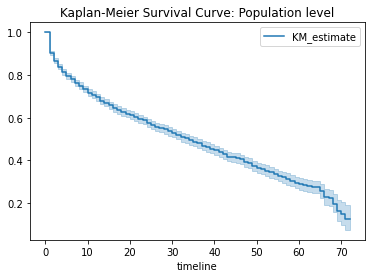

In [17]:
kmf.plot(title='Kaplan-Meier Survival Curve: Population level')